BWR Assembly Simulation
Lets consider a fuel assembly with a given configuration. Our objective is to mesh the geometry and solve for scalar fluxes within each mesh element. To do this, we will imploy the Discrete Ordinate (SN) transport method. More details about SN can be found in other notebooks. The core configuration is below. Salmon regions are fuel, green regions are fuel with a burnable absorber, blue regions are water, and yellow regions are control blades (very strong absorption cross sections). This is an 8 group problem, and we will find the fluxes in the mesh element for each group considering downscatter, gtg scatter, and upscatter. We assume that within each cell, the group cross sections are constant. This is obviously not the case due to doppler broadening, but it will make our calculation simpler. The source is also spatially flat in each region (the fission/scatter source is constant in the cell). SN is used in scenarios where there isn't too much anisotropy, uniform source distributions, and significant heterogenuity in 2 dimensions. 

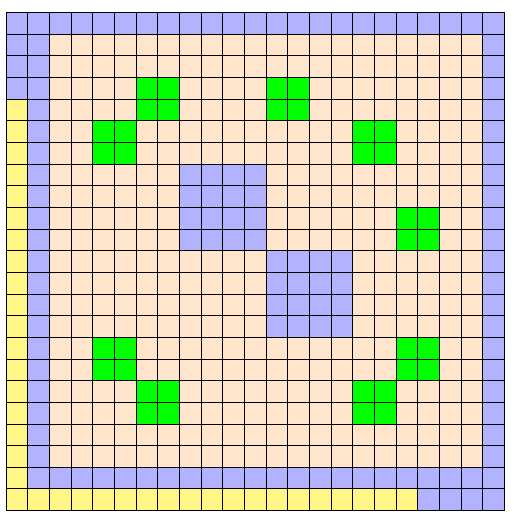

Note, we refining the mesh and extending this problem to three dimensions. What you see here is a assembly numbered from 1 (bottom left) to 529. Each region has it's own associated data. To extend this to 3D, the geometry is initially meshed in the x and y directions to create a 230x230 mesh, and then it is extended in $\hat{z}$ to create a 230x230x230 array. Our final solution will be to plot a heat map of the scalar flux, and the data structure that will be used is a g x $\vec{x}$ matrix (4D).

BWR Assembly Simulation
Lets consider a fuel assembly with a given configuration. Our objective is to mesh the geometry and solve for scalar fluxes within each mesh element. To do this, we will imploy the Discrete Ordinate (SN) transport method. More details about SN can be found in other notebooks. The core configuration is below. Salmon regions are fuel, green regions are fuel with a burnable absorber, blue regions are water, and yellow regions are control blades (very strong absorption cross sections). This is an 8 group problem, and we will find the fluxes in the mesh element for each group considering downscatter, gtg scatter, and upscatter. We assume that within each cell, the group cross sections are constant. This is obviously not the case due to doppler broadening, but it will make our calculation simpler. The source is also spatially flat in each region (the fission/scattering source is constant within the region)

Cell centered finite difference scheme
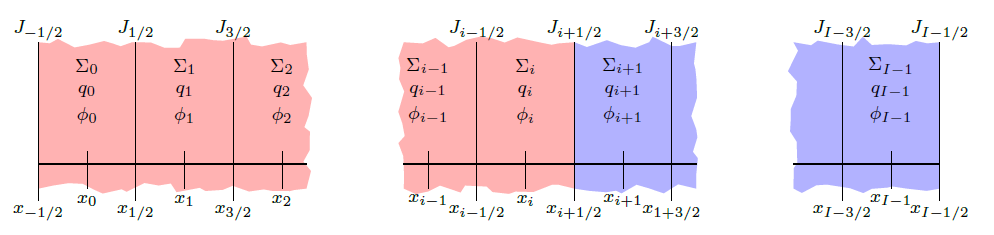

We arrive at SN as our solver after considering ray tracing. Ray tracing is an effective method of getting very detailed information on the fuel pin. Larger calculations are prohibitively expensive, so we try to find a different way. The radiation is forced to move along discrete ordinates that correspond to a given quadrature set. In 1D, Gauss Legendre is standard practice. In our case, we are using the quadrature set provided. The spatial domain is resolved by integrating over discrete regions along said ordinates, allowing for one system of coupled equations along the spatial and angular domains. We will use cell centered finite difference, with the boundary fluxes 5 being specified at half integers (i ± ½, j ± ½, and k $\pm$ $\frac{1}{2}$). The weights are normalized such that their sum is equal to $\pi / 2$. 

Now lets consider the neutron transport equation using the finite difference approximation. 
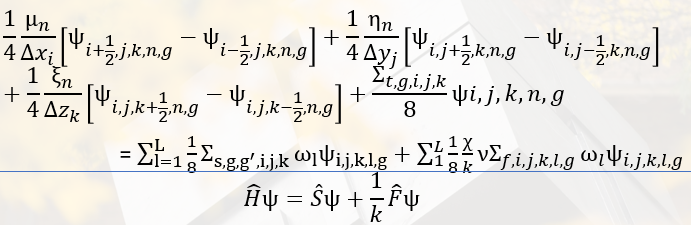

$\mu$, $\eta$, and $\xi$ are the abcissa of the give quadrature set. They are chosen such that for any given ordinate, $\mu^2 + \eta^2 + \xi^2 = 1$. 

Lets get into some code. We need the real spherical harmonic functions to solve this problem, and they are given in the table below. The data provided is only for 1st order anisotropy. If we had more data, we could incorporate higher moments. The data structure of $\hat{R}$ is l x m x ordinate x octant. the 'm' columns go 0,1,-1. Below is importing the data and libraries. 

Real Spherical Harmonic Moments
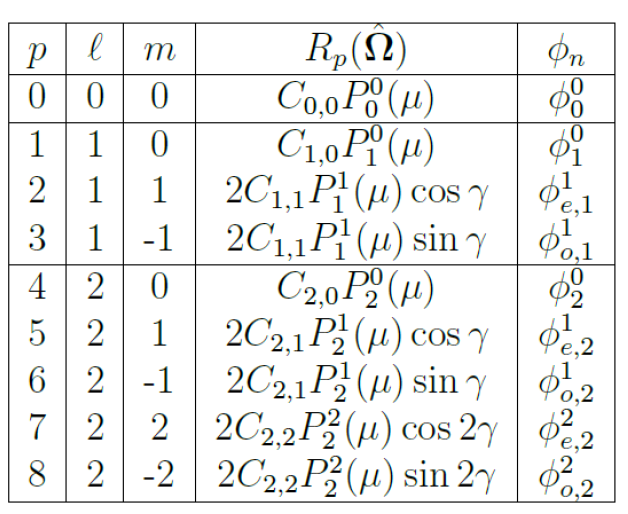

The octants are ordered the following way (+++,-++,--+,+-+,++-,-+-,---,+--).
We can use the converged angular flux moments to find the scalar flux moments using the following relationship:
$\phi_{l,i}^{(m)} = $\sum_{n=0}^{N-1} \omega_n P_l (\mu_n) \psi_{i,n}^{(m)}$.
$\phi$: scalar flux
l: anisotropy moment
i: cell index
m: iteration index
$\omega$: weight
$P_l$: associated Legendre Polynomial
$\mu$: abcissa of the quadrature set. can be replaced with $\eta$ in y and $\xi$ in z. 
$\psi$: angular flux.

We can use this information to guess the source term:
$q_{n,i}^{(m)} = \sum_{l=0}^L \frac{2l + 1}{2} P_l (\mu_n)\Sigma_{sl,i}\phi{l,i}^{(m)} + Q_{i,n}$
q: scattering source
$\Sigma_{sl}$: scattering xs for the lth moment
Q: internal source. for this problem, this is ignored. 

In [1]:
'''
Ravi Shastri
BWR Assembly Sn Solver
7/19/24
'''
import numpy as np
import time
import pandas as pd
import math 
from scipy.special import lpmv # associated legendre function
from scipy.special import sph_harm # spherical harmonic import

# data
ldfe = pd.read_csv('bwr_data/ldfe.csv').values
xs_coarse_lattice =  pd.read_csv('bwr_data/xs_coarse_lattice.csv').values
xs_coarse_lattice_control = pd.read_csv('bwr_data/xs_coarse_lattice_control.csv').values

print('imported')

imported


Now lets get the functions into jupyter because I refuse to use objects

In [2]:
def _xs_data(xs): # set the xs data
    pin_num = xs[:,0]
    pin_group = xs[:,1]
    xs_tot = xs[:,2]
    xs_scat = xs[:,3]
    xs_fis = xs[:,4]
    chi = xs[:,5]
    gtg_p0 = xs[:,6:14]
    gtg_p1 = xs[:,14:22]
    return pin_num, pin_group,xs_tot,xs_scat,xs_fis,chi,gtg_p0,gtg_p1

def _collapse_gtg(gtg):
    counter = 0
    gtg_3D = np.zeros((E_groups,E_groups,pins*pins))
    for k in range(pins*pins):
        for i in range(E_groups):
            for j in range(E_groups):
                gtg_3D[i, j, k] = gtg[counter + i,j]
        counter += 8 
    return gtg_3D

def _collapse_xs(xs):
    xs_2D = np.zeros((E_groups,pins*pins))
    j = k = 0
    for i in range(xs.size):
        xs_2D[j,k] = xs[i]
        j+=1
        if j % E_groups == 0:
            j = 0
            k+=1
    return xs_2D

# construct the 23x23 assembly
def _build_arr(x):
    # initializations
    arr = np.zeros((x,x))
    counter = 0
    # build assembly
    for i in range(x):
        for j in range(x):
            arr[i,j] = 1 + j + x*counter
        counter+=1
    arr = np.flipud(arr)
    return arr

# function to create assembly mesh
def _reshape_array(array, n):
    # initializations on size
    new_shape = (array.shape[0] * n, array.shape[1] * n, array.shape[0] * n)
    new_array = np.zeros(new_shape)
    # mesh the assembly
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            for k in range(array.shape[0]):
                new_array[i*n:(i+1)*n, j*n:(j+1)*n,k*n:(k+1)*n] = array[i,j]
    
    return new_array

# stitch quadrature sets and create omega
def _omega(ldfe):
    # get data out of quadrature set and into arrays
    E_groups = np.count_nonzero(pin_num == 1)
    n        = ldfe[:,0] # num ordinates
    w        = ldfe[:,4] # weights

    # initial quadrature sets. order is (1,2,3,4) = (+,+,+),(-,+,+),(-,-,+),(+,-,+)
    # (5,6,7,8) = (+,+,-),(-,+,-),(-,-,-),(+,-,-)
    mu_q1    = ldfe[:,1]
    eta_q1   = ldfe[:,2]
    xi_q1    = ldfe[:,3]

    # mu's
    mu_q2    = -mu_q1
    mu_q3    = mu_q2
    mu_q4    = mu_q1
    mu_q5    = ldfe[:,3]
    mu_q6    = -mu_q1
    mu_q7    = mu_q2
    mu_q8    = mu_q1

    #eta's
    eta_q2   = eta_q1
    eta_q3   = -eta_q1
    eta_q4   = eta_q3
    eta_q5   = eta_q1
    eta_q6   = eta_q1
    eta_q7   = eta_q3
    eta_q8   = eta_q3

    #xi's
    xi_q2    = xi_q1
    xi_q3    = xi_q1
    xi_q4    = xi_q1
    xi_q5    = -xi_q1
    xi_q6    = xi_q5
    xi_q7    = xi_q5
    xi_q8    = xi_q5

    # build quadrature set for each region
    mu = np.append(mu_q1,[mu_q2,mu_q3,mu_q4,mu_q5,mu_q6,mu_q7,mu_q8])
    eta = np.append(eta_q1,[eta_q2,eta_q3,eta_q4,eta_q5,eta_q6,eta_q7,eta_q8])
    xi = np.append(xi_q1,[xi_q2,xi_q3,xi_q4,xi_q5,xi_q6,xi_q7,xi_q8])
    return E_groups, n, w, mu, eta, xi

# calculate R using quad sets and associated leg poly's
def _calc_R(mu,eta):
    C = np.zeros((leg_moment.size,mom))
    R = np.zeros((mu.size,leg_moment.size,mom))
    # for each ordinate, for each l, for each positive m
    for k in range(mu.size):
        for i in range(mom): # builds the C matrix
            counter = 0
            # dimension of C for 3D should be lxm, m (-1,0,1) in that order
            for j in leg_moment:
                if i >= np.abs(j):
                    C[counter,i] = np.sqrt(2*i+1)*\
                        np.sqrt(math.factorial(i-np.abs(j))/\
                                    math.factorial(i+np.abs(j)))
                else:
                    C[counter,i] = 0
                counter += 1

        for i in range(mom):
            counter = 0
            for j in leg_moment:
                if i == 0:
                    R[k,:,0] = 0
                    R[k,0,0] = 1
                else: 
                    if j != 0:
                        # see report where gamma comes from. it should be the same
                        # if we calculated it from xi.
                        gamma = np.arccos(eta[k]/np.sqrt(1-mu[k]*mu[k]))
                    if j == 0 and i > 0:
                        R[k,counter,i] = C[counter, i]*np.abs(lpmv(j,i,mu[k]))
                        
                    elif j == 1:
                        R[k,counter,i] = 2*C[counter,i]*np.abs(lpmv(j,i,mu[k]))*np.cos(gamma*j)
                        
                    elif j == -1:
                        R[k,counter,i] = 2*C[counter,i]*np.abs(lpmv(j,i,mu[k]))*np.sin(gamma*j)
                    counter += 1
    return R

# flux calculation, sum over ordinances
def _flux(w,m,l,mu,eta,xi,psi):
    phi = 0
    for i in range(mu.size):
        phi += w[i]*sph_harm(m,l,mu[i],eta[i],xi[i])*psi
    return 2*phi

# downscatter function
def _S_fn(gtg_scatter,i,phi,l,m,k,R):
    s = np.zeros((E_groups))
    for m in range(E_groups):
        for j in range(E_groups):
            s[m] += gtg_scatter[j,E_groups,i]*phi[i,l,m,k,j]*R[i,k,m]
    return s

# upscatter function
def _S_fn_up(gtg_scatter,i,phi,l,m,k,R):
    s = np.zeros((E_groups))
    for m in range(E_groups):
        for j in range(E_groups,-1): # -1 reverses the order
            s[m] += gtg_scatter[j,E_groups,i]*phi[i,l,m,k,j]*R[i,k,m]
    return s

def _l2_error_arr(a,b):
    return np.linalg.norm(a-b)

def _l2_error_float(a, b):
    return np.sqrt((a - b) ** 2)

def _grid_space(mu,sigma):
    # returns max space size required to avoid negative fluxes
    return 2*min(np.abs(mu))/sigma

def _reshape_quad(a):
    # input must be a 128x1 array
    return a.reshape(8,16).T

def _reshape_R(array):
    # Reshapes a 128x3x2 array to a 3x2x16x8 array.
    reshaped_array = array.reshape(3, 2, 16, 8)
    return reshaped_array

# k_eff iteration solver
def _k_iter(psi,i,k,g,psi_0,mu,eta,delta,q,phi,l,m):
    LHS = (psi[i,k,g]-psi_0)*mu/delta + (psi[i,k,g]-psi_0)*eta/delta+\
        xs_tot[g,i]*psi[i,k,g] - q[k]
    k_iter = chi[g,i]*xs_fis[g,i]*phi[i,l,m,k,g]/LHS
    return k_iter

In [3]:
# user input, constants, and calculation of the real spherical harmonic moments, R
###############################################################################
mom = 2 # legendre moments
mesh = 10 # mesh x mesh grid in each assembly
pins = 23 # height and width of square assembly 
eps = 1e-6 # tolerance on the flux and source iterations
###############################################################################
# cross sections
# from L -> R
# pin, group, total xs, scat xs, P0 gtg scat xs, P1 gtg scat xs
pin_num, pin_group,xs_tot,xs_scat,xs_fis,chi,gtg_p0,gtg_p1 =\
    _xs_data(xs_coarse_lattice)
k_eff = 1 # initial multiplication factor guess

leg_moment = np.array([0,1,-1])
# omega, including z dependence
E_groups, n, w, mu, eta, xi = _omega(ldfe)
omega = np.column_stack((mu,eta,xi))

# turns the xs's into a group x pin number array
xs_tot  = _collapse_xs(xs_tot)
xs_scat = _collapse_xs(xs_scat)
xs_fis  = _collapse_xs(xs_fis)
chi     = _collapse_xs(chi)

# turns the gtg xs's into a group x group x pin number array (i=8,j=8,k=529)
gtg_0 = _collapse_gtg(gtg_p0)
gtg_1 = _collapse_gtg(gtg_p1)


# make and mesh assembly
assembly_before_mesh = _build_arr(pins)
assembly             = _reshape_array(assembly_before_mesh,mesh)
assembly            -= 1
print(assembly.shape)

# pass in an ordinate
# these are precomputed to increase efficiency. 
R = _calc_R(mu,eta)
R[np.abs(R) < 1e-8] = 0

# reshaping
# abscissa go to 16x8. 16 abcissa in 8 octants
# R goes from 128 x 3 x 2 to 3x2x16x8. m by l by abscissa by octants
mu  = _reshape_quad(mu)
eta = _reshape_quad(eta)
xi  = _reshape_quad(xi)
w   = w.reshape(16,1)
w   = np.tile(w,(1,8))
R   = _reshape_R(R)
print(R.shape)

(230, 230, 230)
(3, 2, 16, 8)


The cell centered angular flux is defined:
$\psi_{i,j,k,n,g} = (\Sigma_{t,i,j,k,n,g} + \frac{2|\mu|}{\Delta x_i} + \frac{2|\eta|}{\Delta y_i} +\frac{2|\xi|}{\Delta z_i})^{-1} \cdot 
(\frac{2|\mu|}{\Delta x_i}\psi_{i \pm 1/2,j,k,n,g} + \frac{2|\eta|}{\Delta y_i}\psi_{i,j \pm 1/2,k,n,g} + \frac{2|\xi|}{\Delta z_i}\psi_{i,j,k\pm 1/2,n,g} + q_{i,j,k,n,g}) $

We introduce the Diamond Difference relationship to apply closure in each dimension. 

$\psi_{i,j,k,n,g} = 1/2 (\psi{i-1/2,j,k,n,g} + \psi_{i+1/2,j,k,n,g})$ 

$\psi_{i,j,k,n,g} = 1/2 (\psi{i,j-1/2,k,n,g} + \psi_{i,j+1/2,k,n,g})$ 

$\psi_{i,j,k,n,g} = 1/2 (\psi{i,j,k-1/2,n,g} + \psi_{i,j,k+1/2,n,g})$ 

For more information, see Brian's 561 Lecture notes. 


Here's the SN solver algorithm

In [4]:
# sn solver
# write this. 

We test convergence using the standard L2 norm.
$\epsilon \leq \frac{\sum_{l=0}^L \sum_{i=0}^{I-1} (\phi_{l,i}^{(m+1)} - \phi_{l,i}^{(m)})^2}{\sum_{l=0}^L \sum_{i=0}^{I-1}(\phi_{l,m}^{(m)})^2}$

Once this number is below the tolerance (1e-6), we consider it converged and we generate color plots. 